In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

import sys
sys.path.append("/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev")
from misc import *

In [2]:
wolf_dir = "/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF"

wolf_vid_fs = glob(wolf_dir + "/*")

test_vid_f = wolf_vid_fs[0]

In [3]:
test_vid_f

'/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF/IMG_0156.MP4'

In [4]:
vid = load_video(test_vid_f, frames = 1000)
vid = decrease_res_by_x(vid, int(1920/4), int(1080/4))

In [5]:
b = bs(vid)

12:25:23 - converting list to array
12:25:23 - clipping video based on thresh
12:25:24 - Getting MEDIAN frame
12:25:25 - Getting STD frame
12:25:25 - subtracting mean and dividing std
12:25:25 - creating mask based off of K = 2
12:25:25 - ******** DONE! ********


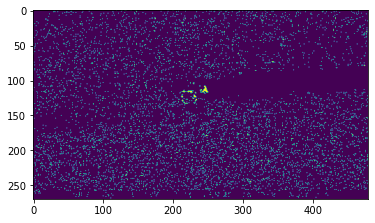

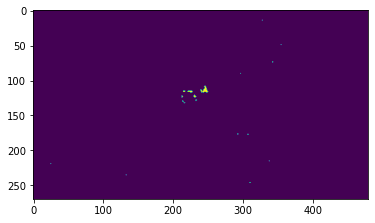

In [6]:
from scipy.signal import medfilt

b0=b[0, ...]
bf0 = medfilt(b0)

plt.imshow(b0)
plt.show()
plt.imshow(bf0)
plt.show()

In [11]:
from tqdm import tqdm

filtered = np.zeros(b.shape)
for i, frame in tqdm(enumerate(b)):
    filtered[i, ...] = medfilt(frame)

filtered.shape

1000it [00:45, 21.76it/s]


(1000, 270, 480)

In [13]:
save_video(filtered, 'filt')

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/filt.mp4


In [6]:
save_video(bs, "test")

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/test.mp4


In [15]:
wolf_activation = np.sum(filtered.reshape((1000, -1)), axis = 1)
wolf_activation.shape

(1000,)

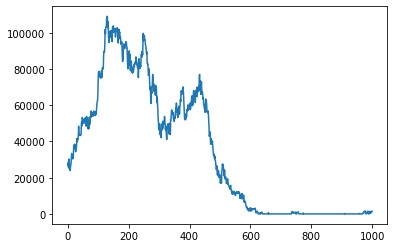

In [16]:
plt.plot(wolf_activation)

In [ ]:
"""
frame filter:
    decrease resolution of video (vid/4)
    perform background suppression on video 
    use a median filter to denoise frames (save this somewhere)
    
    if activation is above (0.01)*(frame area) then there is a wolf in there
    get a list of indices where activation is 1 and 0. 
    write on original video "wolf"/"no wolf" at those indices
    save manipulated video
"""